# Introduction
### In this notebook, I will be showing how to use a Convolutional Neural Network to create a model that should be able to identify digits from 0 to 9 from an image. The dataset is the MNist dataset which can be directly accessed through PyTorch. The model architecture that will be used is the famous Lenet-5 developed by Yann LeCun.

## Import Libraries

To get started, we'll need to import some libraries from pytorch. In addition, we will also use matplotlib.pyplot to see our image data and test data

In [1]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

We will import requests to get an image from the internet to test our model. We also need the *Image* module from the *PIL* library because that is what our testing image will be, an image. We also need to import the *copy* library in order to copy our model later on.

In [2]:
import requests
from PIL import Image
from io import BytesIO

import copy

In our last import, we import other useful libraries such as sklearn only to see the confusion matrix of our model, pandas to see the confusion matrix as a table of values, and numpy.

In [3]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

Set the batch size to 64

In [4]:
numb_batch = 64

## Getting Data

We need to transform the image into a tensor that can be used, so we do *torchvision.transforms.ToTensor()*.

We get the training data from the Mnist library and set *download* to True. Then we need to transfrom the images.
The same can be done for the validation data except that that *train* is False. 

We also need the dataloaders for each dataset and set the batch size to the wanted number, 64.

In [5]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

## Creating the Model

For the Mnist dataset, we will be using the LeNet 5 architecture as shown below:

    ![title](Lenet-5.png)
Image from https://www.researchgate.net/profile/Sheraz_Khan8/publication/321586653/figure/fig4/AS:568546847014912@1512563539828/The-LeNet-5-Architecture-a-convolutional-neural-network.png

In [9]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

## Validating the Model

This validation will use the validation set of handwritten digits and compute how many images are predicted right out of the total number of images. This is just a simple loop through every image in the validation dataloader

In [7]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

## Training Function

For training, we will set the default value to 3 epochs, the learning rate to 0.001, and the device to the cpu of the computer. These can be changed by using parameters when calling the *train* function.

We will use Cross Entropy Loss as our loss function of choice and the Adam optimizer.

An array of accuracies of the validation set is also being kept to plot the graph after the training process is finished for us to see how the model did on the validation.

We only want the best model, so we have to keep a max_accuracy variable and keep updating it if a new accuracy is higher than maximum. Then we just copy the best model into *best_model* and then return *best_model* at the end of the function.

In [8]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

## GPU Availability

Now we check if a GPU is available. If so, then we can use it. If not, then we must resort to using the CPU.

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")

In [7]:
device

device(type='cuda', index=0)

## Training the Model

Now we will call the training function to actually train the model. Since the function will return the best model, we store it in the name *lenet*. I chose to call the function with 30 epochs but you can try different values and see what works best. Since I have a GPU available to use, I need to set the parameter to the GPU. If you do not have a GPU available, you can leave out the *device=device* because by default the function will use the CPU.

Saving Best Model with Accuracy:  95.68000030517578
Epoch: 1 Accuracy : 95.68000030517578 %
Saving Best Model with Accuracy:  97.31999969482422
Epoch: 2 Accuracy : 97.31999969482422 %
Saving Best Model with Accuracy:  97.98999786376953
Epoch: 3 Accuracy : 97.98999786376953 %
Saving Best Model with Accuracy:  98.5
Epoch: 4 Accuracy : 98.5 %
Epoch: 5 Accuracy : 98.47000122070312 %
Epoch: 6 Accuracy : 98.4000015258789 %
Epoch: 7 Accuracy : 98.4000015258789 %
Epoch: 8 Accuracy : 98.12000274658203 %
Saving Best Model with Accuracy:  98.79000091552734
Epoch: 9 Accuracy : 98.79000091552734 %
Epoch: 10 Accuracy : 98.58999633789062 %
Epoch: 11 Accuracy : 98.44000244140625 %
Epoch: 12 Accuracy : 98.7300033569336 %
Epoch: 13 Accuracy : 98.22000122070312 %
Epoch: 14 Accuracy : 98.68000030517578 %
Epoch: 15 Accuracy : 98.7300033569336 %
Saving Best Model with Accuracy:  98.86000061035156
Epoch: 16 Accuracy : 98.86000061035156 %
Epoch: 17 Accuracy : 98.81999969482422 %
Epoch: 18 Accuracy : 98.860000

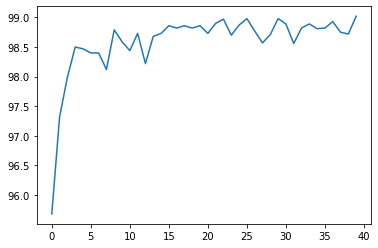

In [49]:
lenet = train(40, device=device)

## Saving the model

We can save the model using *torch.save()* and give a path and name for the model

If you want to save it in the same place you are using the notebook, you can just give the model name as shown below:

In [82]:
torch.save(lenet.state_dict(), "lenet.pth")

## Optional: Loading the saved model 

If you saved the model, and don't want to train again, you can just load the model from the path

In [10]:
lenet = create_lenet().to(device)
lenet.load_state_dict(torch.load("lenet.pth"))
lenet.eval()

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten()
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

## Creating the Function to test validation data

Although we were already using the validation data to find the accuracy of our model, we also want to see where the model got confused. In order to do this, we will have a list of predictions and ground truth for every image in the validation set.

In [11]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

Call the function and store it in two numpy arrays that are returned from the *predict_dl* function

In [12]:
y_pred, y_true = predict_dl(lenet, val_dl)

## Confusion Matrix

Now that we have two numpy arrays of the predictions and the ground truth, we can use the confusion matrix feature from sklearn.

We are showing this confusion matrix through a pandas dataframe.

Hopefully, since our model was somewhere in the neighborhood of 99% accurate with the validation dataset, there should be little confusion between digits.

In [13]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,977,0,0,0,0,0,0,0,2,1
1,0,1134,0,0,0,1,0,0,0,0
2,0,1,1028,0,0,0,0,0,2,1
3,2,0,0,990,0,7,0,1,4,6
4,0,0,0,0,976,0,1,1,0,4
5,2,0,0,3,0,886,1,0,0,0
6,7,4,0,0,4,2,938,0,3,0
7,0,2,1,0,1,0,0,1020,2,2
8,5,0,3,3,1,1,0,1,959,1
9,0,1,0,0,6,4,0,2,2,994


## Define Inference function to get prediction for any given image

Now that we are confident that our model is pretty good at classifying digits, we can get any image with a single digit in it and see what the model predicts!

We use the requests library to get the path and then we can access the contents of the path. This is where we use the *Image* module from *PIL* to open the image from the path. Then we need to resize it to (28, 28) in order to be accessible by the model. 

Finally, we call the model with the transformed image (from PIL image to tensor). We must send in an image as a float and set to the device we want to use. After the model predicts and returns an output, we need to do a *softmax* in order to normalize the output into probablity (0.0 to 1.0)

In [14]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

## Getting the image from the web

We can simply just copy the image's address from the internet and paste it in the string *path*. Then, we can access the contents of the image and resize it, similar to what we did in the inference function.

#### Important: If the image's address is really long, then there will be an error. If this happens, try using a different image with a smaller address.

In [25]:
path = "https://c8.alamy.com/comp/HXBRW0/2-red-handwritten-digits-over-white-background-HXBRW0.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

## Showing the image
Now that we have successfully transformed the image and resized it, we can see what the image looks like. If the image looks very different (meaning that the image has been stretched or shrunk significantly) than what it originally was from the internet, chances are that the model might predict incorrectly.

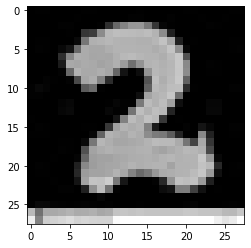

In [26]:
plt.imshow(x.squeeze(-1), cmap="gray")

## Predictions
Now its time to get the prediction for the image. We can just call the *inference* function, which will then call the model itself. We have to tell the function which model to use, as well as which device to use: CPU or GPU.

Once we receive the predictions, a numpy array of size 10 - for 0 to 9 digits, we have to find index of the array that has the largest value, which means that the model is most confident in that answer. To do this, we use the built-in *argmax* function of numpy.

Finally, we can just print the index, which is the digit predicted, as well as the probability (as a percent done by multiplying by 100), which is nothing but the value of the *pred* array at the index.

In [27]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 2, Prob: 100.0 %


Here we can just show every the whole numpy array to see the model's prediction of the probability of each digit (0 - 9) being the digit in the image. A really good model should be able to distinguish greatly between the correct digit and the other 9 incorrect digits.

In this case, only 8 is even close to or at 1 (100 % probability), whereas the other digits are very close to 0 (0 % probability)

In [28]:
pred

array([[3.8190421e-16, 4.1869504e-11, 1.0000000e+00, 8.2445465e-12,
        2.7881241e-20, 5.0278743e-16, 5.4344697e-12, 1.3035397e-15,
        3.0033712e-11, 1.5618705e-16]], dtype=float32)